In [ ]:
import os
os.getcwd()

'/content'

In [1]:
import json
import time
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score

import torch
from torch import cuda
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, BertTokenizer, BertForSequenceClassification, AdamW
from transformers import BartTokenizer

from nli_classifier import NLI_Classifier
from bisection_algorithm import BisectionAnnotator
from fine_tune_bert import BERT_FineTuner
from fine_tune_bart_mnli import BART_MNLI_FineTuner

In [ ]:
tqdm.pandas()

# Sentiment in news about the economy

## Pre-processing steps

### Load data

In [6]:
df = pd.read_csv("../../data/Economy/ground-truth-dataset-cf.csv")
df_train = pd.read_csv("../../data/Economy/5AC_preprocessed.csv")

In [ ]:
df_train["all_text"] = df_train.apply(lambda x: x["headline"] + ".\n" + x["text"], axis=1)

In [ ]:
df_train

,articleid,headline,date,text,relevance,disagreement,positivity,label,Sentences,ZSL
0,nyt_122875445,Study Rebuts Antiboycott-Law Quahns,1976-09-06,! Fears that New York will 'suffer a serious l...,yes,False,3.666667,negative,"['Study Rebuts Antiboycott-Law Quahns', '!', '...",[{'sequence': 'Study Rebuts Antiboycott-Law Qu...
1,nyt_113327613,MISS KELLER GETS SPECIAL CITATION: HONORED BY ...,1955-11-15,"! Helen Keller, who has been both blind and de...",yes,False,6.000000,positive,"[""MISS KELLER GETS SPECIAL CITATION: HONORED B...","[{'sequence': ""MISS KELLER GETS SPECIAL CITATI..."
2,118699621,CREDIT MARKETS EXTEND DECLINE: Interest Levels...,1969-03-14,"! The credit markets, buffeted, .by renewed ta...",yes,False,6.500000,positive,['CREDIT MARKETS EXTEND DECLINE: Interest Leve...,[{'sequence': 'CREDIT MARKETS EXTEND DECLINE: ...
3,112256319,EASING OF MONEY SEEN: Reserve Action Is Held L...,1952-06-15,! The dominant position of the [Federal Reserv...,yes,False,4.000000,negative,['EASING OF MONEY SEEN: Reserve Action Is Held...,[{'sequence': 'EASING OF MONEY SEEN: Reserve A...
4,119495573,RUMSFELD ORDERS BEEF PRICE WATCH: Directs Tax ...,1972-09-08,"! WASHINGTON, Sept. 7 (AP) —The Cost of Living...",yes,False,3.500000,negative,['RUMSFELD ORDERS BEEF PRICE WATCH: Directs Ta...,[{'sequence': 'RUMSFELD ORDERS BEEF PRICE WATC...
...,...,...,...,...,...,...,...,...,...,...
3885,116311600,Reports on Business Conditions in U.S.: New Yo...,1962-12-02,■. Department store sales in the ^country for ...,yes,False,6.666667,positive,['Reports on Business Conditions in U.S.: New ...,[{'sequence': 'Reports on Business Conditions ...
3886,nyt_109026601,When Employers Rule by Whim: Workers who get f...,1992-02-21,■A JMATT DARCY managed to live for 31 WffH yea...,yes,False,8.000000,positive,['When Employers Rule by Whim: Workers who get...,[{'sequence': 'When Employers Rule by Whim: Wo...
3887,108897851,Can We All Sleep Under Bridges?: THE BANKRUPTI...,1992-04-12,■AMERICANS are painfully aware that their econ...,yes,False,2.666667,negative,['Can We All Sleep Under Bridges?: THE BANKRUP...,[{'sequence': 'Can We All Sleep Under Bridges?...
3888,110599182,Are Corporations Less Charitable?: Not Selfish...,1988-02-21,"■AST fall, as the drop in the stock market rat...",yes,False,4.000000,negative,['Are Corporations Less Charitable?: Not Selfi...,[{'sequence': 'Are Corporations Less Charitabl...


In [ ]:
df["Sentences"] = df["Sentences"].apply(eval)
df_train["Sentences"] = df_train["Sentences"].apply(eval)

### Get entailment scores

In [ ]:
CLAIMS = {
    "1": "The economy is performing well overall",
    "0": "The economy is performing badly overall",
}

In [2]:
classifier = NLI_Classifier(CLAIMS, None, source_column="Sentences")

In [ ]:
df["ZSL"] = df["Sentences"].progress_apply(lambda x: classifier.classifier(x, list(CLAIMS.values()), hypothesis_template="{}", multi_label=False))

100%|██████████| 420/420 [03:11<00:00,  2.19it/s]


In [ ]:
df_train["ZSL"] = df_train["Sentences"].progress_apply(lambda x: classifier.classifier(x, list(CLAIMS.values()), hypothesis_template="{}", multi_label=False))

100%|██████████| 3890/3890 [23:13<00:00,  2.79it/s]


In [ ]:
df["ZSL_proc"] = df["ZSL"].apply(lambda x: {r["sequence"]: {l: s for l,s in zip(r["labels"], r["scores"])} for r in x})

In [ ]:
df["ZSL_proc"].iloc[0]

{"Nation's Governors See a Dismal Economic Outlook and a Slow Recovery": {'The economy is performing badly overall': 0.9930779933929443,
  'The economy is performing well overall': 0.006922033149749041},
 'WASHINGTON -.The nation’s governors said Saturday that passage of a $787 billion bill to stimulate the economy might help them avert draconian budget cuts, but that they did not expect to see signs of an economic recovery until late this year or early 2010.': {'The economy is performing badly overall': 0.9319603443145752,
  'The economy is performing well overall': 0.0680396631360054},
 'The officials, arriving here for the winter meeting of the National Governors Association, said that state revenues were coming in far below their projections and that the new federal measure, while helpful, would not be a panacea.': {'The economy is performing badly overall': 0.9311349987983704,
  'The economy is performing well overall': 0.06886501610279083},
 'Gov. Jon Huntsman Jr. of Utah, where 

### Aggregate entailment scores across sentences for the same article

In [ ]:
df["score_pos"] = df["ZSL_proc"].apply(lambda x: sum([x[k]['The economy is performing well overall'] for k in x])/len(x))
df["score_neg"] = df["ZSL_proc"].apply(lambda x: sum([x[k]['The economy is performing badly overall'] for k in x])/len(x))

In [ ]:
df["score_neg_in_dict"] = df["score_neg"].apply(lambda x: {"The economy is performing badly overall": x})
df["score_pos_in_dict"] = df["score_pos"].apply(lambda x: {"The economy is performing well overall": x})

### Get annotations for claims

In [ ]:
df["NEG_annot"] = df["positivity"].apply(lambda x: 1 if x == "negative" else 0)
df["POS_annot"] = df["positivity"].apply(lambda x: 1 if x == "positive" else 0)

In [ ]:
df_train["NEG_annot"] = df_train["label"].apply(lambda x: 1 if x == "negative" else 0)
df_train["POS_annot"] = df_train["label"].apply(lambda x: 1 if x == "positive" else 0)

## BART_MNLI with 0.5 threshold

### Get predictions

In [ ]:
df["pred"] = df.apply(lambda x: "negative" if x["score_neg"] > x["score_pos"] else ("positive" if x["score_neg"] < x["score_pos"] else None), axis=1)

In [ ]:
print(classification_report(df['positivity'].to_list(), df['pred'].to_list()))

              precision    recall  f1-score   support

    negative       0.73      0.86      0.79       258
    positive       0.69      0.50      0.58       162

    accuracy                           0.72       420
   macro avg       0.71      0.68      0.68       420
weighted avg       0.71      0.72      0.71       420



## Ours: BART_MNLI with threshold-tuning

### Get thresholds

In [ ]:
df_train_sub = df_train[df_train["label"] != "ambiguous"]


ANNOT NB: 47
MEDIAN: 0.550

INTERVAL: 0.490 - 0.820 	==> WIDTH: 0.330
TOTAL = 1.0
LEFT MASS = 0.700 	RIGHT MASS = 0.300 	TOTAL = 1.000



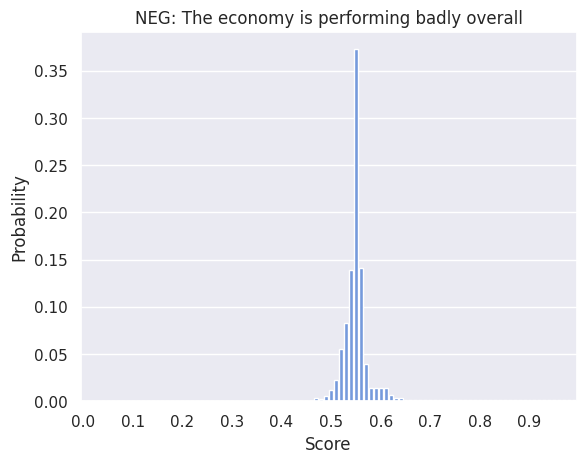

NEED TO STOP ANNOTATING! Data is too sparse


*********************************
***  THRESHOLD FOUND: 0.550   ***
*********************************



<ipython-input-32-1e0bef833540>:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[class_idx + '_annot'] = self.df['text'].apply(lambda x: '' if not x in self.cache else (1 if self.cache[x] == 1 else (0 if self.cache[x] == 0 else '')))


In [ ]:
# for trait_class, compare_class in ASSIGNED_CLASSES:

trait_class = "NEG"
trait_idx = "NEG"
trait_text = "The economy is performing badly overall"
class_text = "The economy is performing badly overall"

annotator = BisectionAnnotator(df_train_sub, step=0.01, early_termination_width=0.05, level='sub-claim')
_, out_dict, early_stop = annotator(trait_idx, trait_text, trait_class, class_text, column='score_neg_in_dict')

with open("./" + trait_idx + '_record_TRAIN.json', 'w') as file:
    json.dump(out_dict, file)

In [ ]:
threshold = out_dict["thresholds"][-1]

In [ ]:
df["pred_test"] = df["score_neg"].apply(lambda x: "negative" if x > threshold else "positive")

In [ ]:
print(classification_report(df['positivity'].to_list(), df['pred_test'].to_list()))

              precision    recall  f1-score   support

    negative       0.80      0.80      0.80       258
    positive       0.68      0.68      0.68       162

    accuracy                           0.75       420
   macro avg       0.74      0.74      0.74       420
weighted avg       0.75      0.75      0.75       420



## Prompting with Llama 3

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
training_examples_clean = {
    "1": {
        "Neg": "Airlines Fearing a Vicious Circle Of Weak Finances and Low Morale: Squeezing Labor Costs",
        "Pos": "Reserve Chief Optimistic on the Economy -- Calls Inflation Curb 'Vital'",
    },
}

In [ ]:
CLAIMS = {

    "1": "The economy is performing well overall",
    # "0": "The economy is performing badly overall",

}

prompt = '''Decide whether the claim text implies the claim, answering with YES or NO. For example:

Text: {POS_EXP}
Claim: {CLAIM}
Answer: Yes

Text: {NEG_EXP}
Claim: {CLAIM}
Answer: No

Text: {TWEET}
Claim: {CLAIM}
Answer: '''

In [ ]:
def get_LLAMA_pred(text_frmtd, claim_nb, prompt):
    prompt_frmt = prompt.format(
        TWEET=text_frmtd,
        CLAIM=CLAIMS[claim_nb].strip(),
        POS_EXP=training_examples_clean[claim_nb]["Pos"],
        NEG_EXP=training_examples_clean[claim_nb]["Neg"],
    )

    # Tokenize the prompt
    inputs = tokenizer(prompt_frmt, return_tensors="pt").to(device)

    # Get the logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the logits for the last token
    logits = outputs.logits[:, -1, :]

    # Apply softmax to get probabilities
    probs = F.softmax(logits, dim=-1)

    # Tokenize "Yes" and "No"
    yes_token_id = tokenizer.convert_tokens_to_ids("Yes")
    no_token_id = tokenizer.convert_tokens_to_ids("No")

    # Get the probabilities of "Yes" and "No"
    yes_token_prob = probs[0, yes_token_id].item()
    no_token_prob = probs[0, no_token_id].item()

    results = {"Prompt": prompt_frmt, "Yes": yes_token_prob, "No": no_token_prob}

    return results

In [ ]:
def create_all_text(row):
    tokens = row["text"].split()
    if len(tokens) > 500:
        new_text = " ".join(tokens[:500]) + " [...]"
    else:
        new_text = row["text"]
    merged_text = row["headline"] + ". " + new_text
    return merged_text

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B"
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quantization_config, device_map=device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
start = time.time()

for claim in CLAIMS:

    print("Claim", claim)
    print()
    df["Text_all"] = df.apply(create_all_text, axis=1)
    columns = df.columns

    responses = list()

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        text_preproc = row["Text_all"]
        r = get_LLAMA_pred(text_preproc, claim, prompt)
        responses.append(r)

    df["LLAMA3_responses"] = responses

    df.to_csv("../economy_claim_" + claim + "_LLAMA3_v2.csv", index=False)

end = time.time()

print(end - start)

In [ ]:
df["pred"] = df["LLAMA3_responses"].apply(lambda x: "positive" if x["Yes"] > x["No"] else "negative")

In [ ]:
print(classification_report(df["positivity"].to_list(), df["pred"].to_list()))

## Fine-tuned BERT

### Load models

In [ ]:
label_to_ix = {"negative": 0, "positive": 1}
device = 'cuda' if cuda.is_available() else 'cpu'
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
fine_tuner = BERT_FineTuner(label_to_ix, device, tokenizer)

In [ ]:
# Replace current categorical label in test set by numeric label
df["label"] = df["positivity"].to_list()

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                                                      num_labels = 2, # The number of output labels--2 for binary classification.
                                                      output_attentions = False, # Whether the model returns attentions weights.
                                                      output_hidden_states = False, # Whether the model returns all hidden-states.
                                                      return_dict=False
)

model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

### Upsample training data for better performance

In [ ]:
df_sub = df_train[df_train["label"] != "ambiguous"]

In [ ]:
df_TRAIN = df_sub.sample(frac=0.7)
df_DEV = df_sub[~df_sub["all_text"].isin(df_TRAIN["all_text"].to_list())]

In [ ]:
df_sub_pos_TRAIN = df_TRAIN[df_TRAIN['label'] == "positive"]
n_samples = len(df_TRAIN) - 2*len(df_sub_pos_TRAIN)
df_list = [df_TRAIN, df_sub_pos_TRAIN.sample(n_samples, replace=True)]
df_sub_UP_TRAIN = pd.concat(df_list).sample(frac=1)

### Create datasets

In [ ]:
training_set = fine_tuner.create_BERT_training_dataset(df_sub_UP_TRAIN)
validation_set = fine_tuner.create_BERT_training_dataset(df_DEV)
testing_set = fine_tuner.create_BERT_testing_dataset(df)

In [ ]:
train_iterator = DataLoader(training_set, batch_size = 4, shuffle = True)
valid_iterator = DataLoader(validation_set, batch_size = 4, shuffle = False)
test_iterator = DataLoader(testing_set, batch_size = 4, shuffle = False)

### Fine-tuned BERT

In [ ]:
fine_tuner.train_and_evaluate(model, optimizer, train_iterator, valid_iterator, './Economy_models', epochs=3, model_name = 'BERT_model')

### Get inferences

In [ ]:
testing_set = fine_tuner.create_BERT_testing_dataset(df)
test_iterator = DataLoader(testing_set, batch_size = 16, shuffle = False)

In [ ]:
def predict(model, iterator):
    '''Predict using model. '''
    results = list()

    # Turm off dropout while evaluating
    model.eval()

    # No need to backprop in eval
    with torch.no_grad():

        for batch in tqdm(iterator):

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            _, logits = model(b_input_ids,
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels)

            logits = torch.nn.functional.softmax(logits, dim=1)
            results += logits.cpu().detach().tolist()

    return results

In [ ]:
checkpoint = torch.load("./Economy_models/BERT_model_best.pt")
print("Epoch:", checkpoint['epoch'])
model.load_state_dict(checkpoint['model_state'])

In [ ]:
df['BERT_pred'] = predict(model, test_iterator)
df['BERT_pred'] = df['BERT_pred'].apply(lambda x: x[1])

In [ ]:
print(classification_report(df["positivity"].to_list(), df["BERT_pred"].to_list()))

## Fine-tuned BART_MNLI

In [ ]:
def concat_headlines_and_body(headline, sentences, max_len=250):
    new_text = headline + ". "
    nb_words = len(headline.split())
    for s in sentences:
        nb_words += len(s.split())
        if nb_words > max_len:
            break
        new_text += s + " "
    return new_text

In [ ]:
df_train_sub = df_train.drop_duplicates()
df_train_sub = df_train_sub[df_train_sub["label"] != "ambiguous"]
df_train_sub["all_text"] = df_train_sub.apply(lambda x: concat_headlines_and_body(x["headline"], x["Sentences"]), axis=1)
df_train_sub_sub  = df_train_sub.sample(frac=0.9)
df_dev = df_train_sub[~df_train_sub["all_text"].isin(df_train_sub_sub["all_text"].to_list())]

In [ ]:
hypotheses = {
    "positive": "The economy is performing well overall",
    "negative": "The economy is performing badly overall"
}
batch_size = 4
nb_classes = 2
nb_epochs = 20
warmup_ratio = 0.4
device = 'cuda' if cuda.is_available() else 'cpu'
training_sizes = [100, 500, 1000, 2500, 5000, 10000]

In [ ]:
# Load the BART tokenizer.
tokenizer = BartTokenizer.from_pretrained(
    'facebook/bart-large-mnli',
    do_lower_case=True,
)

In [ ]:
fine_tuner = BART_MNLI_FineTuner(hypotheses, batch_size, nb_classes, nb_epochs, warmup_ratio, device, tokenizer, training_sizes)

In [ ]:
df["all_text"] = df.apply(lambda x: concat_headlines_and_body(x["headline"], x["Sentences"]), axis=1)
df["label"] = df["positivity"].to_list()

In [ ]:
fine_tuner(df_train_sub_sub, df_dev, df)